In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
google_stock_data =pd.read_csv('GOOG.csv')

In [4]:
google_stock_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [5]:
google_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.7+ KB


In [6]:
google_stock_data = google_stock_data[['date','open','close']]
google_stock_data['date'] = pd.to_datetime(google_stock_data['date'].apply(lambda x: x.split()[0]))
google_stock_data.set_index('date',drop=True,inplace=True)
google_stock_data.head()

,open,close
date,,
2016-06-14,716.48,718.27
2016-06-15,719.00,718.92
2016-06-16,714.91,710.36
2016-06-17,708.65,691.72
2016-06-20,698.77,693.71


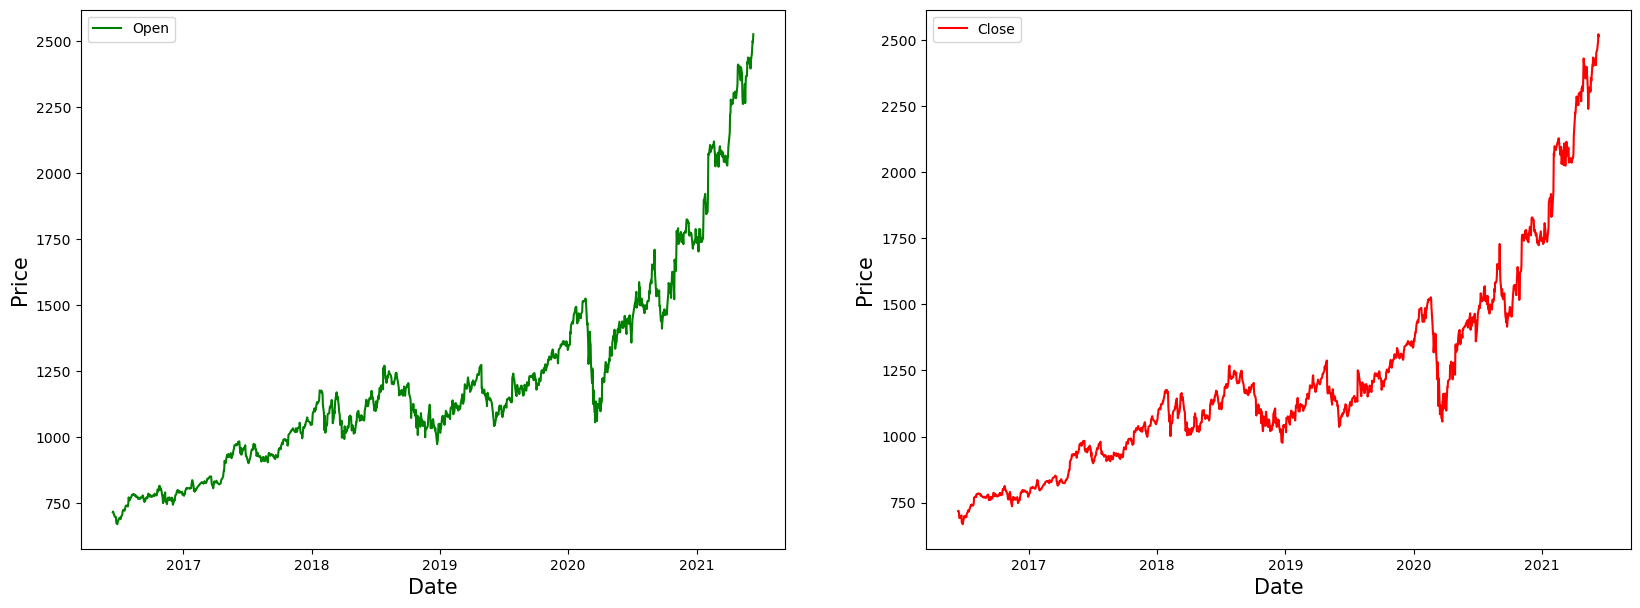

In [7]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(google_stock_data['open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(google_stock_data['close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()

fg.show()

In [8]:
#Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
MMS=MinMaxScaler()
google_stock_data[google_stock_data.columns] = MMS.fit_transform(google_stock_data)

In [9]:
google_stock_data.shape

(1258, 2)

In [10]:
training_size = round(len(google_stock_data)*0.80)
training_size

1006

In [11]:
train_data =google_stock_data[:training_size]
test_data = google_stock_data[training_size:] 

In [12]:
train_data.shape,test_data.shape

((1006, 2), (252, 2))

In [13]:
def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [14]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [15]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((956, 50, 2), (956, 2), (202, 50, 2), (202, 2))

Building LSTM Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout ,LSTM ,Bidirectional

In [17]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
30/30 [==============================] - 15s 174ms/step - loss: 0.0073 - mean_absolute_error: 0.0592 - val_loss: 0.0064 - val_mean_absolute_error: 0.0655
Epoch 2/80
30/30 [==============================] - 3s 101ms/step - loss: 8.5533e-04 - mean_absolute_error: 0.0233 - val_loss: 0.0066 - val_mean_absolute_error: 0.0692
Epoch 3/80
30/30 [==============================] - 3s 102ms/step - loss: 5.1853e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0033 - val_mean_absolute_error: 0.0463
Epoch 4/80
30/30 [==============================] - 3s 101ms/step - loss: 4.9975e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0027 - val_mean_absolute_error: 0.0411
Epoch 5/80
30/30 [==============================] - 3s 102ms/step - loss: 4.6134e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0026 - val_mean_absolute_error: 0.0401
Epoch 6/80
30/30 [==============================] - 3s 106ms/step - loss: 5.0123e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0051 - val_mean_absolute_error: 0.

In [20]:
test_predicted = model.predict(test_seq)
test_predicted[:5]


7/7 [==============================] - 0s 29ms/step


array([[0.48060775, 0.49149975],
       [0.48601252, 0.4973071 ],
       [0.49171644, 0.50311524],
       [0.5079692 , 0.5180638 ],
       [0.5164809 , 0.5269964 ]], dtype=float32)

In [22]:
test_inverse_predicted = MMS.inverse_transform(test_predicted)
test_inverse_predicted[:5]

array([[1562.0083, 1579.1761],
       [1572.0283, 1589.9391],
       [1582.6029, 1600.7036],
       [1612.7343, 1628.4083],
       [1628.5143, 1644.9635]], dtype=float32)

In [24]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([google_stock_data.iloc[-202:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=google_stock_data.iloc[-202:].index)], axis=1)

In [25]:
gs_slic_data[['open','close']] = MMS.inverse_transform(gs_slic_data[['open','close']])

In [26]:
gs_slic_data.head()

,open,close,open_predicted,close_predicted
date,,,,
2020-08-24,1593.98,1588.20,1562.008301,1579.176147
2020-08-25,1582.07,1608.22,1572.028320,1589.939087
2020-08-26,1608.00,1652.38,1582.602905,1600.703613
2020-08-27,1653.68,1634.33,1612.734253,1628.408325
2020-08-28,1633.49,1644.41,1628.514282,1644.963501


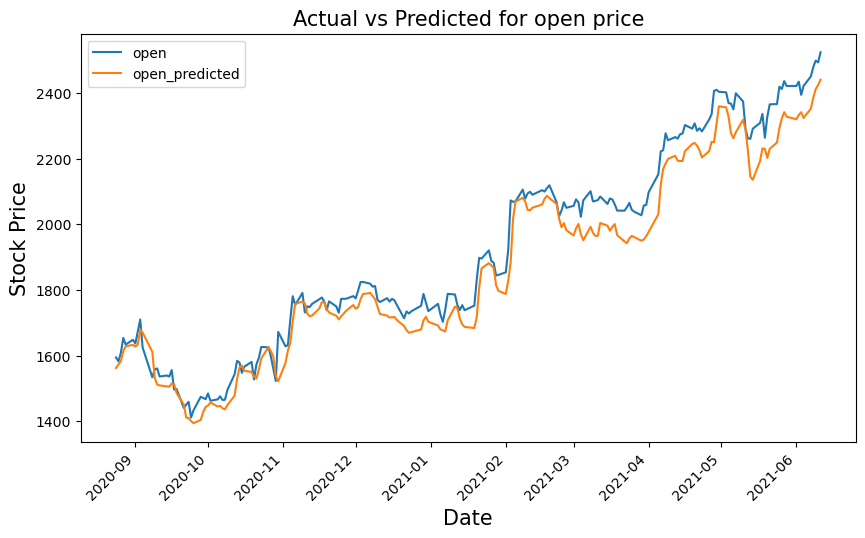

In [28]:
gs_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

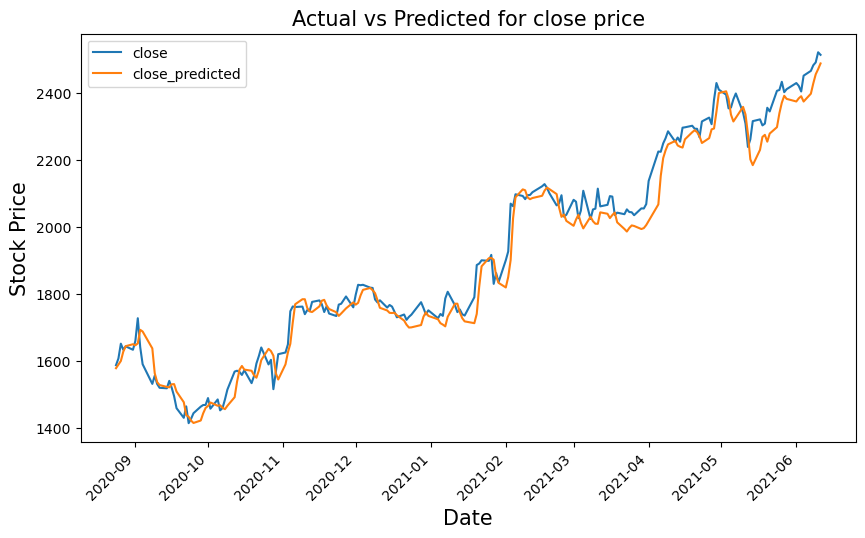

In [29]:
gs_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

Predicting for upcoming 10 Days

In [31]:
# Creating a dataframe and adding 10 days to existing index 

gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))

In [33]:
gs_slic_data['2021-06-09	':'2021-06-16']

,open,close,open_predicted,close_predicted
2021-06-09,2499.50,2491.40,2412.633301,2455.866699
2021-06-10,2494.01,2521.60,2425.068359,2471.264648
2021-06-11,2524.92,2513.93,2441.140137,2488.244873
2021-06-12,NaN,NaN,NaN,NaN
2021-06-13,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN


In [34]:
upcoming_prediction = pd.DataFrame(columns=['open','close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [35]:
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)

1/1 [==============================] - 0s 79ms/step


In [36]:
upcoming_prediction[['open','close']] = MMS.inverse_transform(upcoming_prediction[['open','close']])

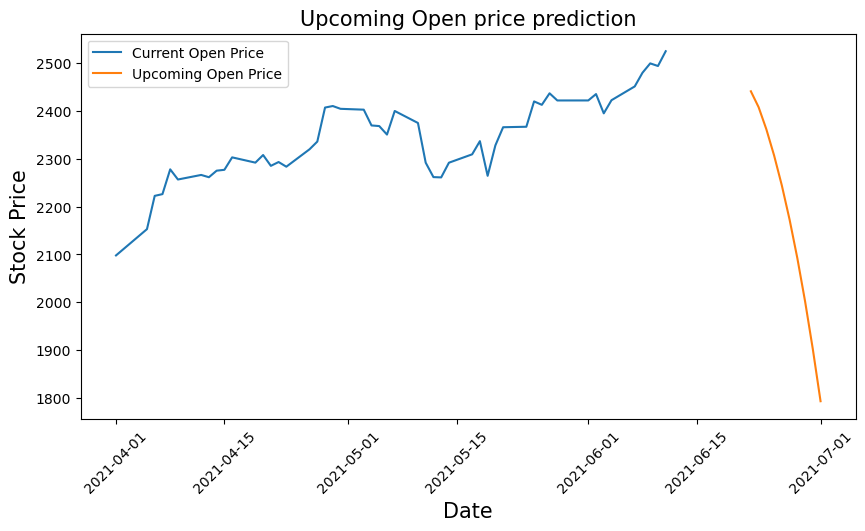

In [37]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()

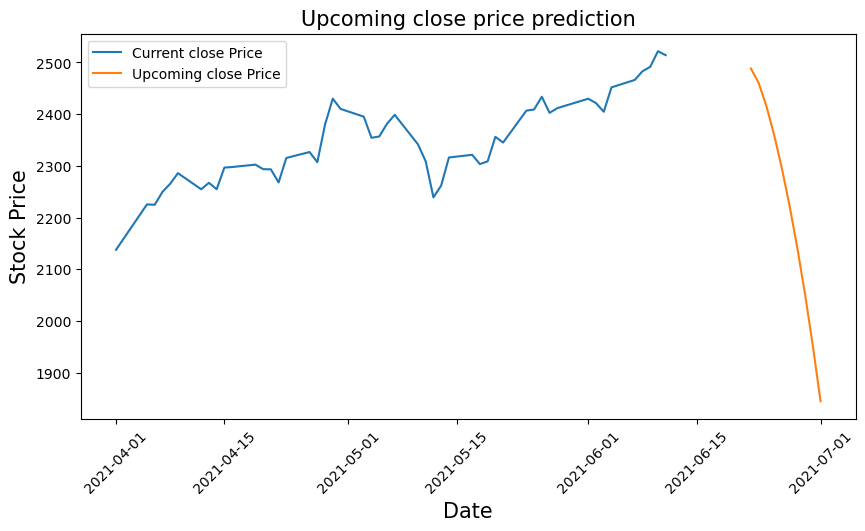

In [38]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()

ThankYou